In [1]:
import os 
import numpy as np
from PIL import Image
from torchvision import transforms
import torchvision.datasets as datasets
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import ViTForImageClassification
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Define dataset paths
train_dir = '/kaggle/input/skin-cancer-img-augmented/skincancerimg/train'
test_dir = '/kaggle/input/skin-cancer-img-augmented/skincancerimg/test'

In [3]:
# Custom dataset class
class CustomDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = Image.open(path).convert('RGB')  # Ensure RGB format
        image = np.array(image)
        
        # Apply transformations
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [4]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.179, 0.179, 0.179], std=[0.175, 0.175, 0.175])  # Using calculated mean/std
])

In [5]:
# Load datasets
train_dataset = CustomDataset(root=train_dir, transform=transform)
test_dataset = CustomDataset(root=test_dir, transform=transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Load ViT model with 9 classes
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch32-384', 
    num_labels=9, 
    ignore_mismatched_sizes=True  # Fixes shape mismatch
)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-384 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 5
losses, accuracies = [], []

In [15]:
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    epoch_loss = 0
    
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=loss.item())

    losses.append(epoch_loss / len(train_loader))

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

Epoch [1/5]: 100%|██████████| 141/141 [05:52<00:00,  2.50s/it, loss=0.602]


Accuracy: 67.13%


Epoch [2/5]: 100%|██████████| 141/141 [05:50<00:00,  2.49s/it, loss=0.606]


Accuracy: 69.07%


Epoch [3/5]: 100%|██████████| 141/141 [05:51<00:00,  2.49s/it, loss=0.41] 


Accuracy: 67.31%


Epoch [4/5]: 100%|██████████| 141/141 [05:49<00:00,  2.48s/it, loss=0.2]   


Accuracy: 70.28%


Epoch [5/5]: 100%|██████████| 141/141 [05:51<00:00,  2.49s/it, loss=0.156] 


Accuracy: 71.30%


In [24]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 10
losses, accuracies = [], []

In [25]:
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    epoch_loss = 0
    
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=loss.item())

    losses.append(epoch_loss / len(train_loader))

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

Epoch [1/10]: 100%|██████████| 141/141 [05:48<00:00,  2.47s/it, loss=0.026]  


Accuracy: 72.22%


Epoch [2/10]: 100%|██████████| 141/141 [05:45<00:00,  2.45s/it, loss=0.0461]


Accuracy: 71.39%


Epoch [3/10]: 100%|██████████| 141/141 [05:47<00:00,  2.47s/it, loss=0.152] 


Accuracy: 71.20%


Epoch [4/10]: 100%|██████████| 141/141 [05:43<00:00,  2.43s/it, loss=0.185] 


Accuracy: 73.61%


Epoch [5/10]: 100%|██████████| 141/141 [05:47<00:00,  2.47s/it, loss=0.0275] 


Accuracy: 72.69%


Epoch [6/10]: 100%|██████████| 141/141 [05:38<00:00,  2.40s/it, loss=0.071]  


Accuracy: 73.80%


Epoch [7/10]: 100%|██████████| 141/141 [05:44<00:00,  2.44s/it, loss=0.038]  


Accuracy: 70.28%


Epoch [8/10]: 100%|██████████| 141/141 [05:47<00:00,  2.46s/it, loss=0.00141]


Accuracy: 74.63%


Epoch [9/10]: 100%|██████████| 141/141 [05:44<00:00,  2.45s/it, loss=0.00379]


Accuracy: 72.31%


Epoch [10/10]: 100%|██████████| 141/141 [05:47<00:00,  2.47s/it, loss=0.0798]


Accuracy: 66.85%


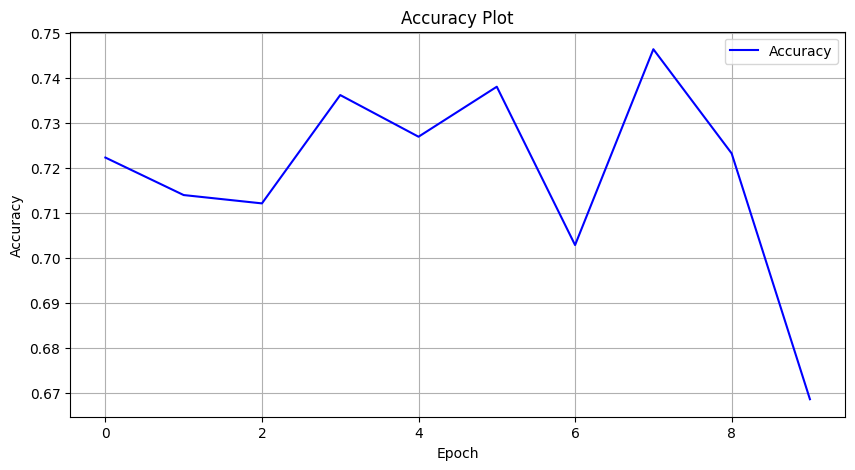

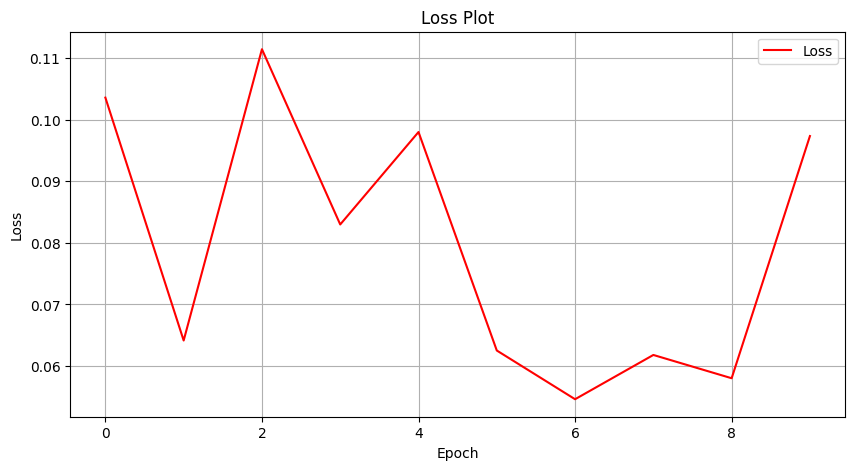

In [26]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.grid(True)
plt.show()

Test Accuracy: 66.39%
Test Loss: 1.3351


<Figure size 800x600 with 0 Axes>

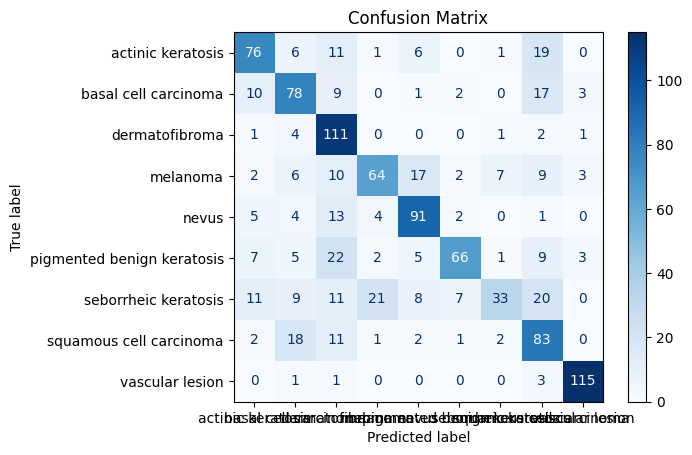

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure model is in evaluation mode
model.eval()

# Initialize variables
correct, total, test_loss = 0, 0, 0
all_preds, all_labels = [], []
criterion = torch.nn.CrossEntropyLoss()

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Store predictions & actual labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final accuracy & loss
test_loss /= len(test_loader)
accuracy = correct / total

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=train_dataset.classes)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Save trained model
torch.save(model.state_dict(), '/kaggle/working/VIT_multiclass.pth')
print("Model saved!")

Model saved!
